# (22) Sim New -- draft

**Motivation**: finally fixed the bug for pursuit condition. it had to do with computing x_env given mask. <br>

In [1]:
# HIDE CODE


import os, sys
from copy import deepcopy as dc
from os.path import join as pjoin
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
extras_dir = pjoin(git_dir, 'jb-MTMST/_extras')
fig_base_dir = pjoin(git_dir, 'jb-MTMST/figs')
tmp_dir = pjoin(git_dir, 'jb-MTMST/tmp')

# GitHub
sys.path.insert(0, pjoin(git_dir, '_MTMST'))
from figures.fighelper import *
from model.opticflow import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
# HIDE CODE


def _create_ticks(of, tick_spacing: int = None):
    if tick_spacing is None:
        tick_spacing = 15 // of.res  # of.fov // 3
    of.ticks, of.ticklabels = zip(*[
        (i, str(int(np.round(np.rad2deg(x))))) for i, x
        in enumerate(of.span) if i % tick_spacing == 0
    ])
    return


def show_thetaphi(t, p):
    fig, axes = create_figure(1, 4, (13, 2.5), tight_layout=True)
    im = axes[0].imshow(t, cmap='nipy_spectral')
    plt.colorbar(im, ax=axes[0])

    im = axes[2].imshow(p, cmap='hsv', vmin=0, vmax=2*np.pi)
    plt.colorbar(im, ax=axes[2])

    for ax in [axes[0], axes[2]]:
        ax.invert_yaxis()
        ax.tick_params(labelsize=10)
        ax.set(
            xticks=of.ticks,
            yticks=of.ticks,
            xticklabels=of.ticklabels,
            yticklabels=of.ticklabels,
        )

    axes[1].axvline(np.deg2rad(fov), color='r', ls='--', label=f'{fov} deg')
    sns.histplot(
        t.ravel(), ax=axes[1], label=r'$\theta$',
        bins=np.linspace(0, np.pi/2, 91), stat='count')
    sns.histplot(
        p.ravel(), ax=axes[3], label=r'$\phi$', color='C0',
        bins=np.linspace(0, 2*np.pi, 37), stat='count')
    
    sns.histplot(
        p[t <= np.deg2rad(fov)], ax=axes[3], label=r'$\phi$' + f' (<{fov})', color='C1',
        bins=np.linspace(0, 2*np.pi, 37), stat='count')
    for ax in [axes[1], axes[3]]:
        ax.set_ylabel('')
        ax.legend(fontsize=8, loc='upper left')

    plt.show()
    
    
def show_xyzd(x, y, z, d, cmap='Spectral', grid=False):
    fig, axes = create_figure(1, 4, (12, 2.5), 'all', 'all', tight_layout=True)
    im = axes[0].imshow(x, cmap=cmap)
    plt.colorbar(im, ax=axes[0])
    axes[0].set_title(r'$\mathcal{x}$', y=1.02, fontsize=17)

    im = axes[1].imshow(y, cmap=cmap)
    plt.colorbar(im, ax=axes[1])
    axes[1].set_title(r'$\mathcal{y}$', y=1.02, fontsize=17)

    im = axes[2].imshow(z, cmap=cmap)
    plt.colorbar(im, ax=axes[2])
    axes[2].set_title(r'$\mathcal{z}$', y=1.02, fontsize=17)

    im = axes[3].imshow(d, cmap=cmap)
    plt.colorbar(im, ax=axes[3])
    axes[3].set_title(r'$\mathcal{d} = \sqrt{\mathcal{x}^2+\mathcal{y}^2+\mathcal{z}^2}$', y=1.02, fontsize=14)

    axes[-1].invert_yaxis()
    for ax in axes.flat:
        ax.tick_params(labelsize=10)
        ax.set(
            xticks=of.ticks,
            yticks=of.ticks,
            xticklabels=of.ticklabels,
            yticklabels=of.ticklabels,
        )
    if grid:
        add_grid(axes)
    plt.show()
    
    
def hist_xyzd(x, y, d, z=None, bins=30):
    kws = {
        'bins': bins,
        'stat': 'percent',
    }
    fig, axes = create_figure(2, 4, (13, 5), sharey='all', constrained_layout=True)
    sns.histplot(x.ravel(), ax=axes[0, 0], **kws)
    sns.histplot(y.ravel(), ax=axes[0, 1], **kws)
    if z is not None:
        sns.histplot(z.ravel(), ax=axes[0, 2], **kws)
    sns.histplot(d.ravel(), ax=axes[0, 3], **kws)

    sns.histplot(x[theta < np.deg2rad(fov)], ax=axes[1, 0], **kws)
    sns.histplot(y[theta < np.deg2rad(fov)], ax=axes[1, 1], **kws)
    if z is not None:
        sns.histplot(z[theta < np.deg2rad(fov)], ax=axes[1, 2], **kws)
    sns.histplot(d[theta < np.deg2rad(fov)], ax=axes[1, 3], **kws)
    
    axes[0, 0].set_title(r'$x$', y=1.02, fontsize=17)
    axes[0, 1].set_title(r'$y$', y=1.02, fontsize=17)
    axes[0, 2].set_title(r'$z$', y=1.02, fontsize=17)
    axes[0, 3].set_title(r'$d$', y=1.02, fontsize=17)
    
    plt.show()

In [3]:
from skimage.transform import resize

fov = 45
dim = 65
res = 2*fov/(dim-1)
res

1.40625

In [ ]:
%%time

self = of = OpticFlow(
    category='fixate',
    num=10000,
    n_obj=2,
    vlim_slf=(0.01, 1.0),
    vlim_obj=(0.01, 1.0),
    fov=fov,
    res=res,
).compute_coords()
_create_ticks(of)
of.alpha.shape

<AxesSubplot:>

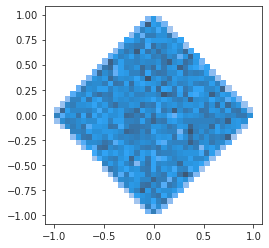

In [5]:
ax = sns.histplot(x=self.fix[:, 0], y=self.fix[:, 1])
ax_square(ax)

In [6]:
self.fix

array([[ 0.27392337, -0.46042657,  1.        ],
       [ 0.21327155,  0.45899312,  1.        ],
       [ 0.08724998,  0.87014485,  1.        ],
       ...,
       [-0.33171479,  0.58736205,  1.        ],
       [-0.78013898, -0.18938395,  1.        ],
       [ 0.2002712 ,  0.31791632,  1.        ]])

In [7]:
%%time

x_obj, v_tr, v_rot = self.compute_flow()

CPU times: user 32.4 s, sys: 5.75 s, total: 38.2 s
Wall time: 38.2 s


In [8]:
for n, obj in self.objects.items():
    for i in range(2):
        corr = sp_stats.pearsonr(self.fix[:, i], obj.pos[:, i] - self.fix[:, i])[0]
        print(f"obj #{n}, i = {i},\tcorr = {corr:0.3f}")

obj #0, i = 0,  corr = 0.026

obj #0, i = 1,  corr = 0.014

obj #1, i = 0,  corr = 0.045

obj #1, i = 1,  corr = 0.036

obj #0, i = 0,  corr = 0.003

obj #0, i = 1,  corr = -0.023

obj #1, i = 0,  corr = 0.038

obj #1, i = 1,  corr = 0.003

In [4]:
self.alpha_dot.shape

NameError: name 'self' is not defined

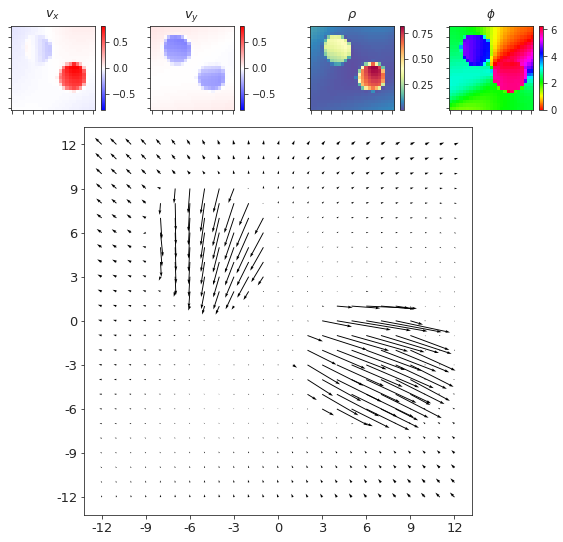

In [44]:
i = 550
d = 25
v = np.zeros((d, d, 2))
v[..., 0] = resize(self.alpha_dot[i, ..., 0], (d,) * 2)
v[..., 1] = resize(self.alpha_dot[i, ..., 1], (d,) * 2)

show_opticflow_full(v);

In [45]:
norms_obj = cart2polar(self.objects[1].v)[:, 0]
norms_slf = cart2polar(self.v_slf)[:, 0]

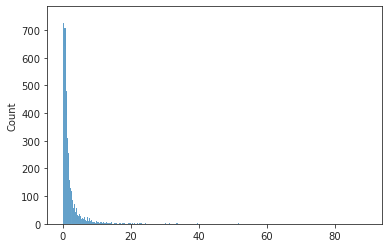

In [46]:
sns.histplot(norms_obj / norms_slf);

In [47]:
i = np.argsort(norms_obj / norms_slf)[-3]
i

4391

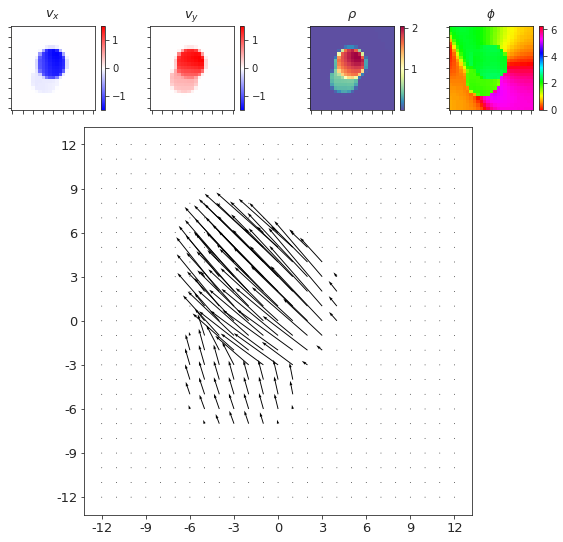

In [48]:
d = 25
v = np.zeros((d, d, 2))
v[..., 0] = resize(self.alpha_dot[i, ..., 0], (d,) * 2)
v[..., 1] = resize(self.alpha_dot[i, ..., 1], (d,) * 2)

show_opticflow_full(v);

In [49]:
self.objects[1].v[i]

array([-0.58819728,  0.66969313, -0.23379128])

In [50]:
self.v_slf[i]

array([0.00778014, 0.00344126, 0.00889283])

In [51]:
i = np.argsort(norms_obj / norms_slf)[0]
i

6861

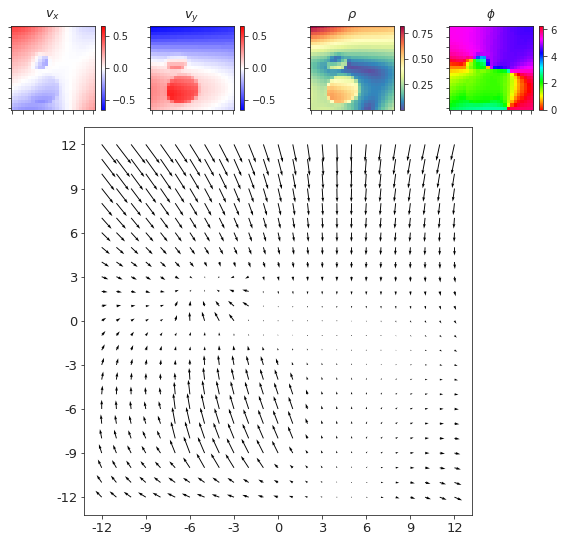

In [52]:
d = 25
v = np.zeros((d, d, 2))
v[..., 0] = resize(self.alpha_dot[i, ..., 0], (d,) * 2)
v[..., 1] = resize(self.alpha_dot[i, ..., 1], (d,) * 2)

show_opticflow_full(v);

In [55]:
self.objects[0].v[i]

array([-0.23966884,  0.31587134,  0.03312895])

In [56]:
self.objects[1].v[i]

array([-0.00163752,  0.00076312,  0.00986885])

In [57]:
self.v_slf[i]

array([ 0.28737914, -0.77473266,  0.3930329 ])

In [58]:
sp_stats.pearsonr(self.objects[0].alpha[:, 0], self.objects[1].alpha[:, 0])

(0.009176406697185273, 0.3588569798080503)

In [59]:
sp_stats.pearsonr(self.objects[0].alpha[:, 1], self.objects[1].alpha[:, 1])

(0.014075694601877737, 0.15929007555335437)

In [60]:
from sklearn.feature_selection import mutual_info_regression

In [61]:
mutual_info_regression(self.objects[0].pos, self.objects[1].pos[:, 0])

array([0.07827392, 0.02002662, 0.01446407])

In [ ]:
collections.Counter(np.round(
    self.alpha_dot[:, self.dim//2, self.dim//2, :], 12).ravel())

In [12]:
print({
    obj_i: obj.v[i, :] for
    obj_i, obj in self.objects.items()
})

{
    1: array([-0.01942597, -0.00594047,  0.00173506]),
    2: array([ 0.77505328,  0.51689838, -0.35485947]),
    3: array([ 0.6160265 , -0.40146984, -0.8869026 ])
}

In [13]:
print({
    obj_i: obj.pos[i, :] for
    obj_i, obj in self.objects.items()
})

{
    1: array([0.15239664, 1.11073912, 0.98994943]),
    2: array([0.3666167 , 0.68877045, 0.92981573]),
    3: array([0.41718809, 0.63856454, 0.49694206])
}

In [14]:
 - self.v_slf[i]

array([-0.39321627,  0.19274517, -0.23184461])

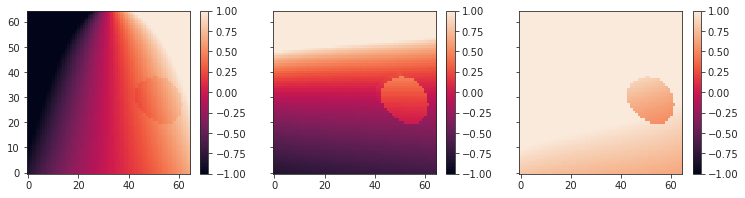

In [15]:
fig, axes = create_figure(1, 3, (12.5, 3), 'all', 'all')
for j, ax in enumerate(axes.flat):
    im = ax.imshow(x_obj[i, ..., j], vmin=-1, vmax=1)
    plt.colorbar(im, ax=ax)
    ax.invert_yaxis()
plt.show()

In [40]:
%%time

fov = 45

self = of = OpticFlow(
    category='pursuit',
    num=10000,
    n_obj=1,
    vlim_slf=(0.01, 1.0),
    vlim_obj=(0.01, 1.0),
    fov=fov,
    res=5,
).compute_coords()
_create_ticks(of)

x_obj, v_tr, v_rot = self.compute_flow()

u, s, v = sp_lin.svd(
    a=flatten_arr(self.alpha_dot, ndim_end=0, ndim_start=1),
    full_matrices=False,
    compute_uv=True,
)
data = v.reshape(-1, self.dim, self.dim, 2)
s *= 100 / s.sum()

CPU times: user 18.7 s, sys: 1.04 s, total: 19.7 s
Wall time: 10.1 s


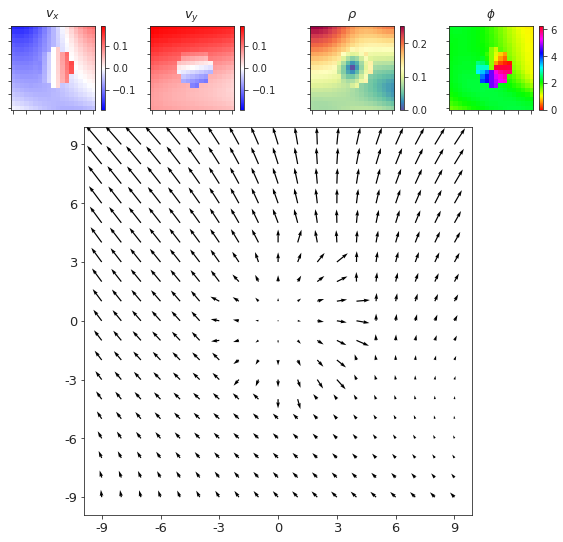

In [42]:
i = 540
show_opticflow_full(self.alpha_dot[i]);

In [43]:
np.round(self.alpha_dot[:, 9, 9], 5)

array([[ 0.,  0.],
       [-0., -0.],
       [-0.,  0.],
       ...,
       [-0.,  0.],
       [ 0.,  0.],
       [-0., -0.]])

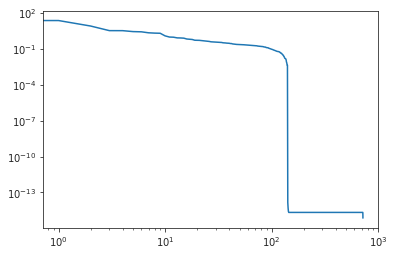

In [44]:
plt.loglog(s)

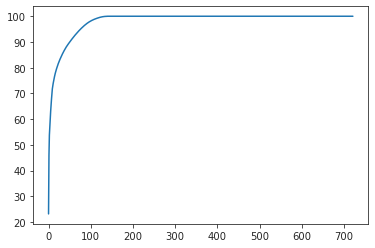

In [45]:
plt.plot(np.cumsum(s))

In [46]:
np.round(s, 1)[:20]

array([23.2, 22.7,  7.9,  3.3,  3.2,  2.7,  2.6,  2.2,  2. ,  2. ,  1.2,
        1. ,  0.9,  0.8,  0.8,  0.8,  0.7,  0.6,  0.6,  0.5])

In [47]:
from skimage.transform import resize
# data = resize(data, (self.num, 19, 19, 2))
# data.shape

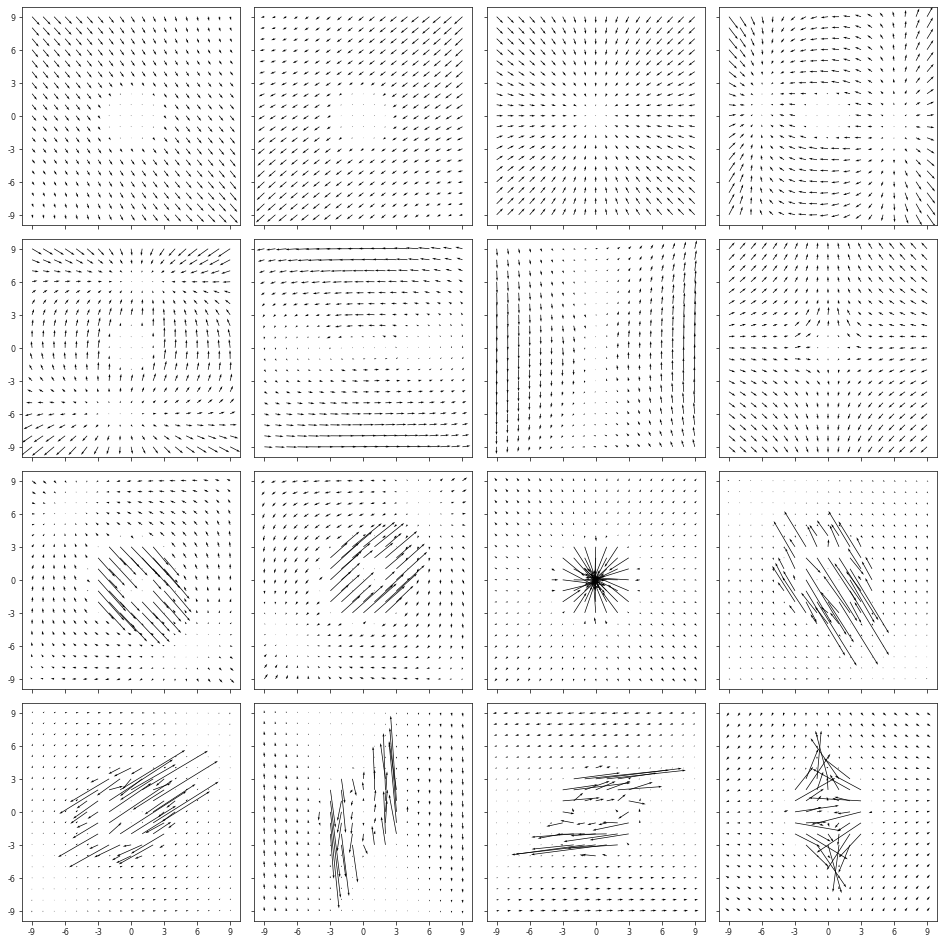

In [48]:
show_opticflow(data, num=4, scale=None, figsize=(13,) * 2);

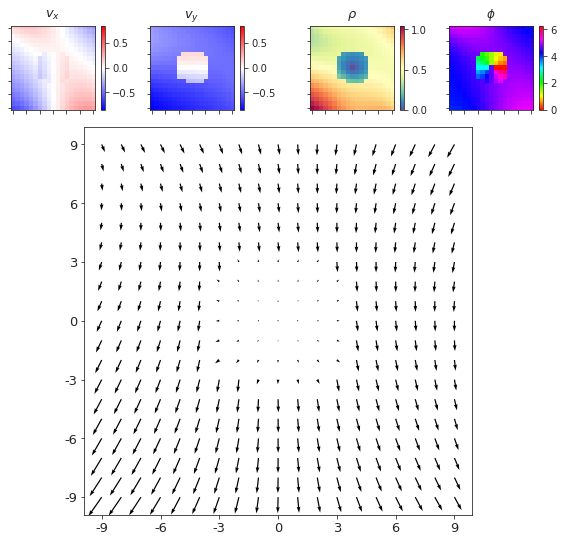

In [49]:
show_opticflow_full(self.alpha_dot[1700]);

In [51]:
dot = np.einsum('ai, ai -> a', self.fix, self.objects[0].pos)
dot /= sp_lin.norm(self.objects[0].pos, axis=-1)
dot /= sp_lin.norm(self.fix, axis=-1)
dot = np.round(dot, 13)
num_fix_and_pos_aligned = collections.Counter(dot)[1.0]
num_center_alpha_dot_zero = collections.Counter(np.round(
    self.alpha_dot[:, self.dim//2, self.dim//2, :], 10).ravel())[0]
assert (
    self.num == num_fix_and_pos_aligned and
    num_center_alpha_dot_zero == 2 * self.num
)
num_fix_and_pos_aligned, num_center_alpha_dot_zero

(10000, 20000)

In [54]:
imin, imax = np.argmin(self.objects[0].size), np.argmax(self.objects[0].size)
imin, imax

(807, 6161)

In [55]:
m = self.compute_obj_mask(self.objects[0].pos)

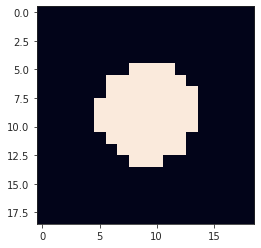

In [58]:
plt.imshow(m[imax])

<AxesSubplot:ylabel='Count'>

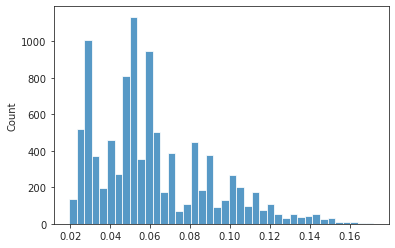

In [59]:
sns.histplot(self.objects[0].size)

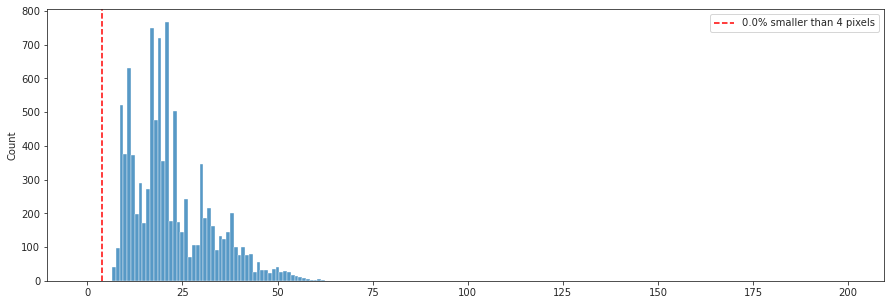

In [60]:
fig, ax = create_figure(1,1,(15, 5))
sns.histplot(m.sum(1).sum(1), bins=np.linspace(0, 200, 201) - 0.5, ax=ax)

thres = 4
lbl = f'{100 * (m.sum(1).sum(1) < thres).sum() / self.num:0.1f}% smaller than {thres} pixels'
ax.axvline(thres, color='r', ls='--', label=lbl)
ax.legend();

In [122]:
%%time

fov = 45

self = of = OpticFlow(
    category='pursuit',
    num=10000,
    n_obj=1,
    vlim_slf=(0, 0),
    vlim_obj=(0.01, 1.0),
    obj_zlim=(0.3, 0.6),
    obj_r=0.3,
    fov=fov,
    res=5,
).compute_coords()
_create_ticks(of)

x_obj, v_tr, v_rot = self.compute_flow()

u, s, v = sp_lin.svd(
    a=flatten_arr(self.alpha_dot, ndim_end=0, ndim_start=1),
    full_matrices=False,
    compute_uv=True,
)
data = v.reshape(-1, self.dim, self.dim, 2)
s *= 100 / s.sum()

CPU times: user 20.6 s, sys: 1.15 s, total: 21.7 s
Wall time: 11.1 s


In [123]:
np.round(s, 1)[:20]

array([9.1, 9. , 3.3, 2.1, 2.1, 1.8, 1.6, 1.5, 1.2, 1. , 1. , 0.9, 0.9,
       0.8, 0.7, 0.7, 0.7, 0.6, 0.6, 0.6])

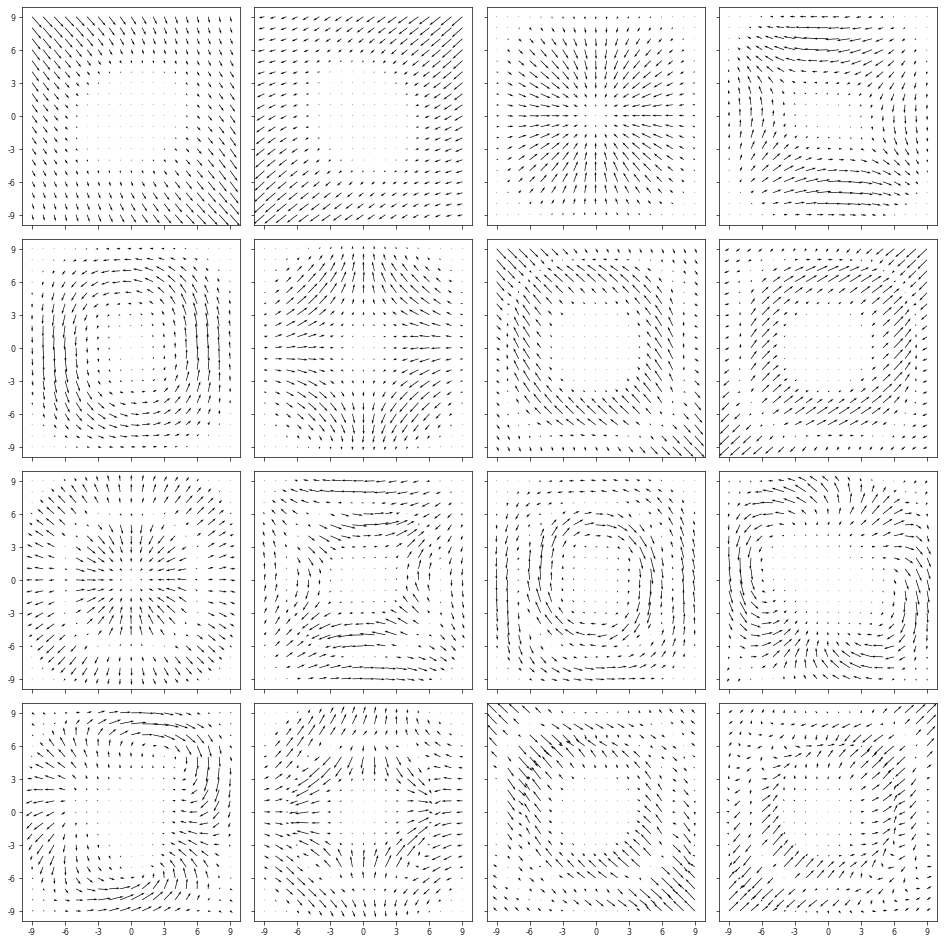

In [124]:
show_opticflow(data, num=4, scale=None, figsize=(13,) * 2);

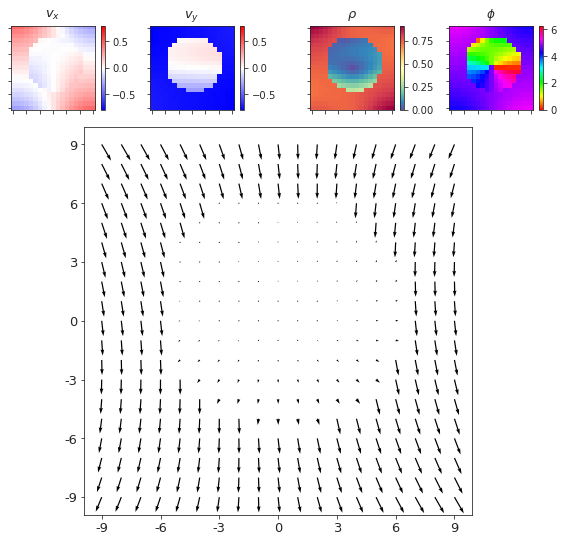

In [130]:
i = 570
show_opticflow_full(self.alpha_dot[i]);

In [126]:
self.objects[0].v[i], self.objects[0].pos[i]

(array([ 0.86034904, -0.08916345,  0.38157321]),
 array([-0.27518942, -0.21658276,  0.49635807]))

In [103]:
m = self.compute_obj_mask(self.objects[0].pos)

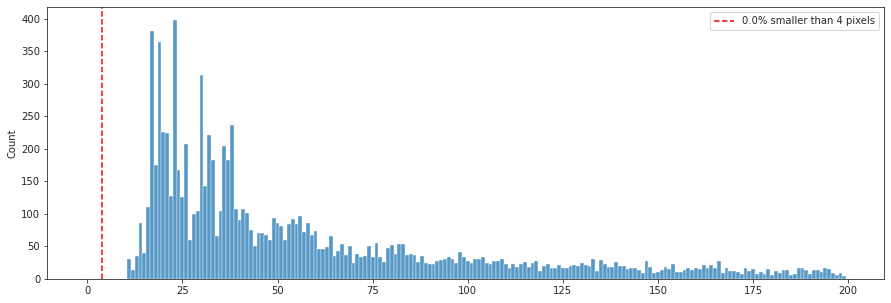

In [104]:
fig, ax = create_figure(1,1,(15, 5))
sns.histplot(m.sum(1).sum(1), bins=np.linspace(0, 200, 201) - 0.5, ax=ax)

thres = 4
lbl = f'{100 * (m.sum(1).sum(1) < thres).sum() / self.num:0.1f}% smaller than {thres} pixels'
ax.axvline(thres, color='r', ls='--', label=lbl)
ax.legend();

In [105]:
accepted = m.sum(1).sum(1) > thres
accepted.sum()

10000

In [106]:
u, s, v = sp_lin.svd(
    a=flatten_arr(self.alpha_dot[accepted], ndim_end=0, ndim_start=1),
    full_matrices=False,
    compute_uv=True,
)
data = v.reshape(-1, self.dim, self.dim, 2)
s *= 100 / s.sum()

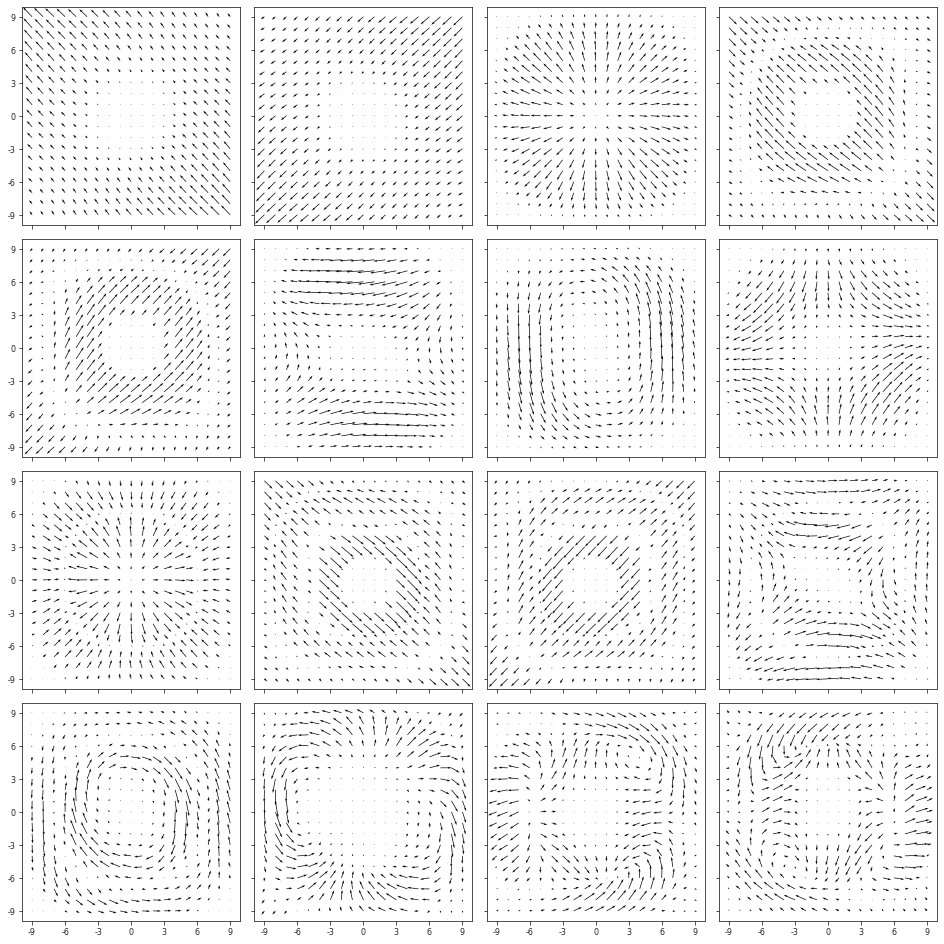

In [107]:
show_opticflow(data, num=4, scale=None, figsize=(13,) * 2);

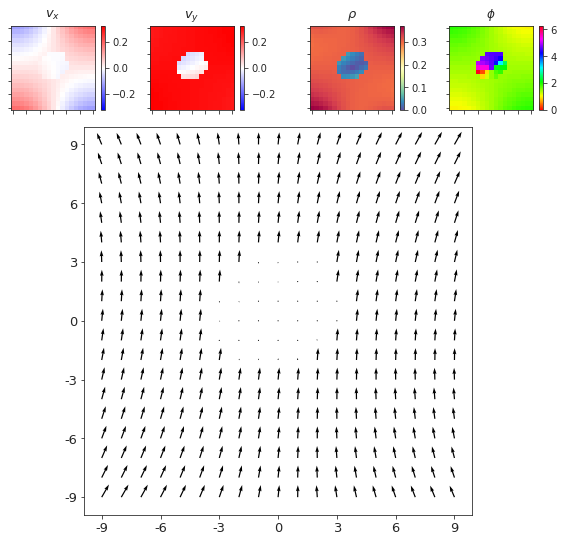

In [99]:
self.objects[0].v[i], self.objects[0].pos[i]

(array([-0.01667229, -0.20598162, -0.02847099]),
 array([ 0.17098469, -0.26687053,  0.56705197]))

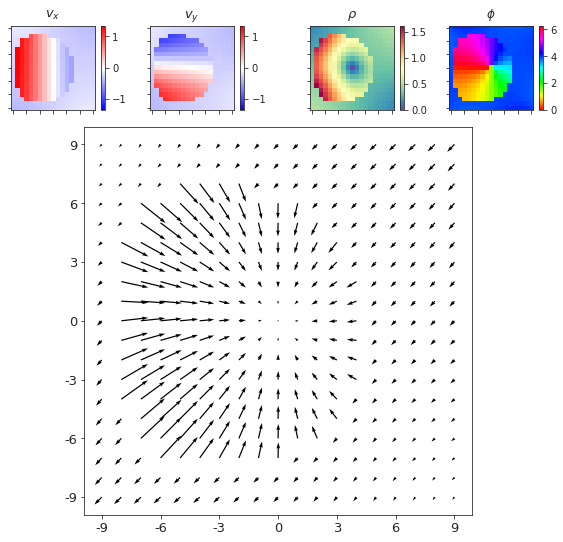

In [132]:
i = 3
show_opticflow_full(self.alpha_dot[i]);

In [133]:
self.objects[0].v[i], self.objects[0].pos[i]

(array([0.50494375, 0.15259131, 0.51850768]),
 array([0.25077471, 0.02862893, 0.34524953]))

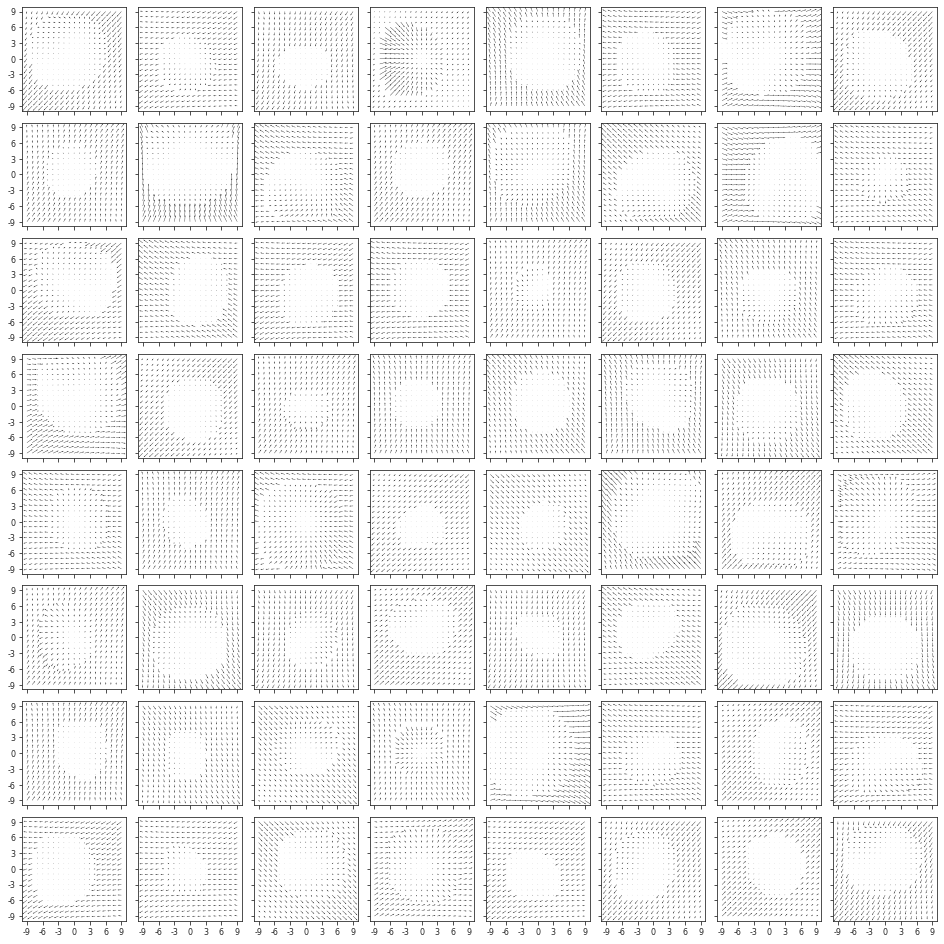

In [131]:
show_opticflow(self.alpha_dot, num=8, scale=None, figsize=(13,) * 2);

In [39]:
self.fix[320]

array([ 0.08004594, -0.85661175,  1.        ])

In [74]:
np.round(s[:10], 4)

array([3.515 , 2.2172, 2.1822, 1.7565, 1.6961, 1.5   , 1.4621, 1.4389,
       1.098 , 1.0716])

In [67]:
d_small = 23
data = np.zeros((100, d_small, d_small, 2))
for i in range(len(data)):
    a = v[i].reshape(self.dim, self.dim, 2)
    data[i, ..., 0] = resize(a[..., 0], (d_small,) * 2)
    data[i, ..., 1] = resize(a[..., 1], (d_small,) * 2)
data.shape

(100, 23, 23, 2)

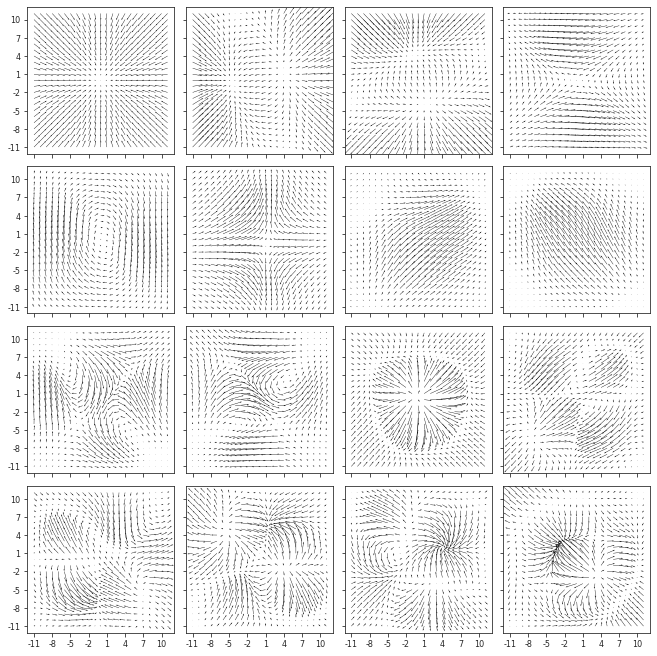

In [68]:
show_opticflow(data, scale=0.3);

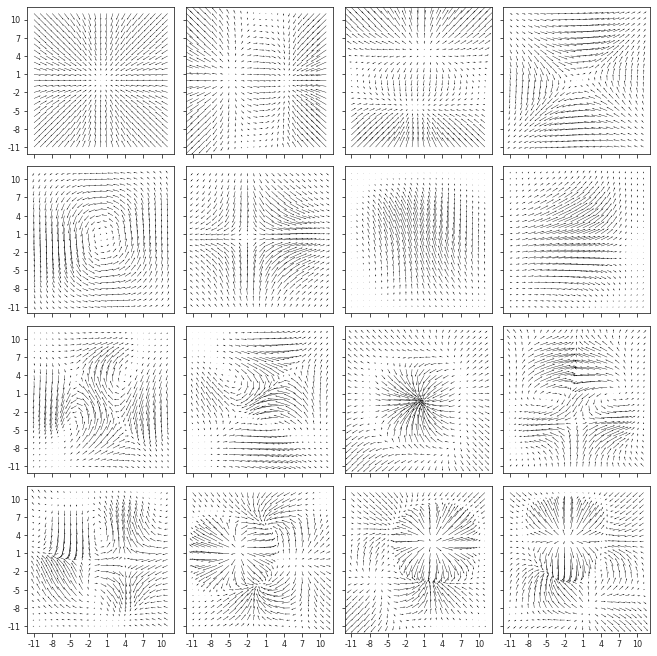

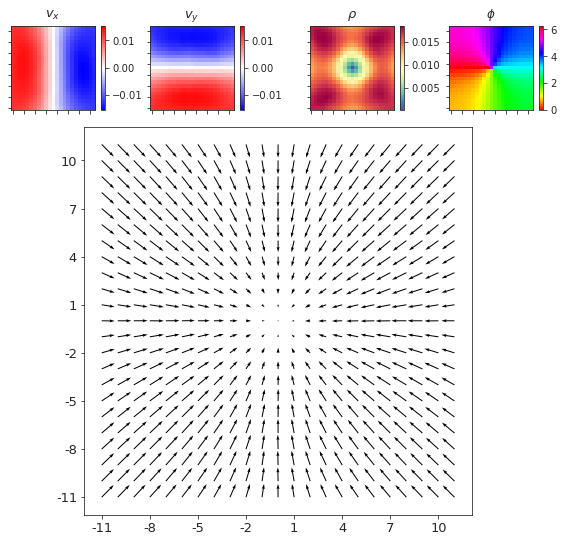

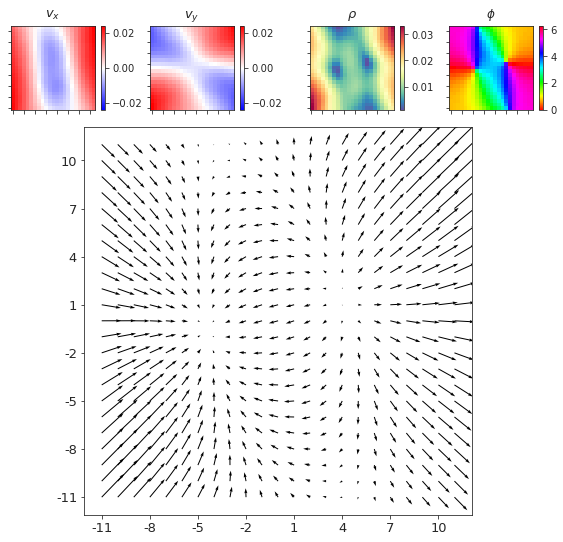

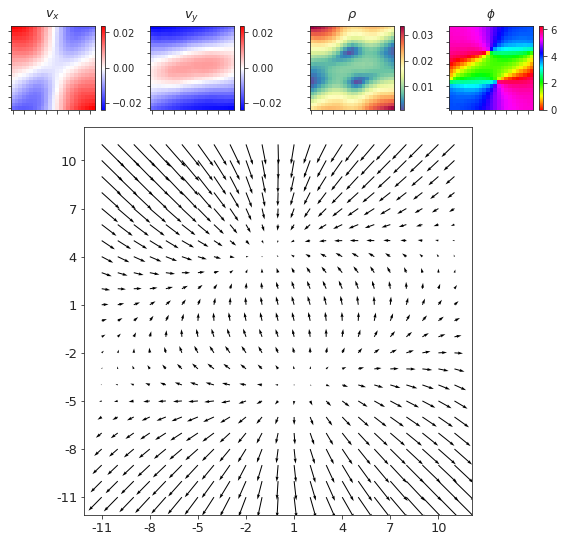

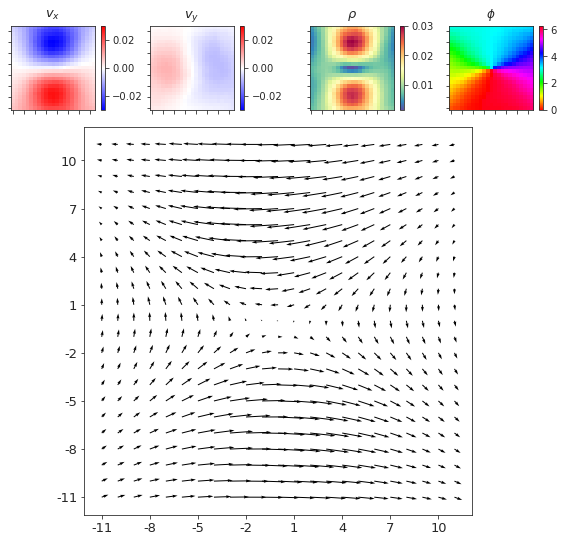

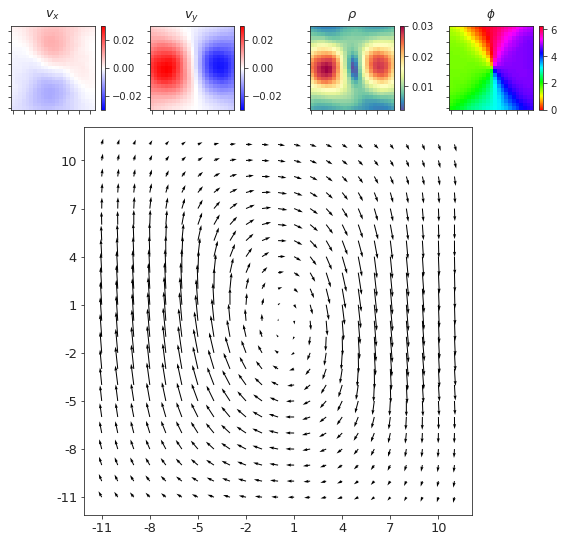

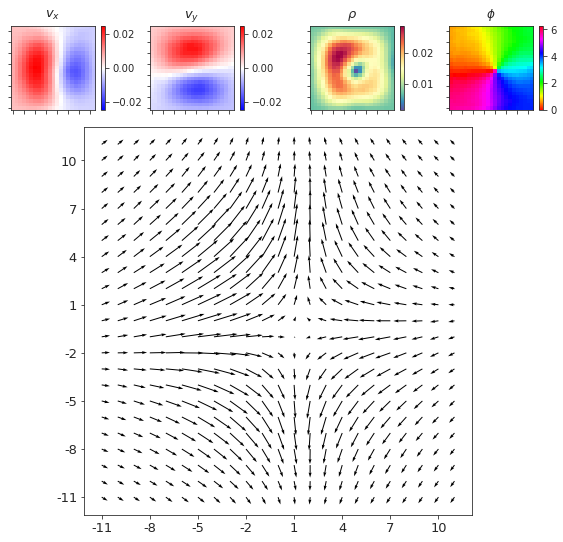

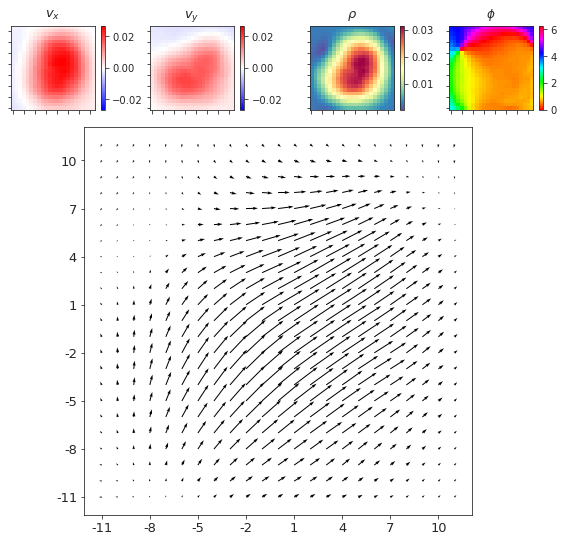

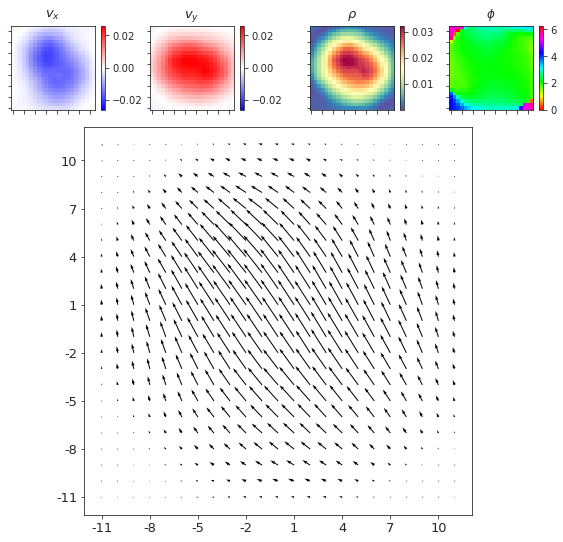

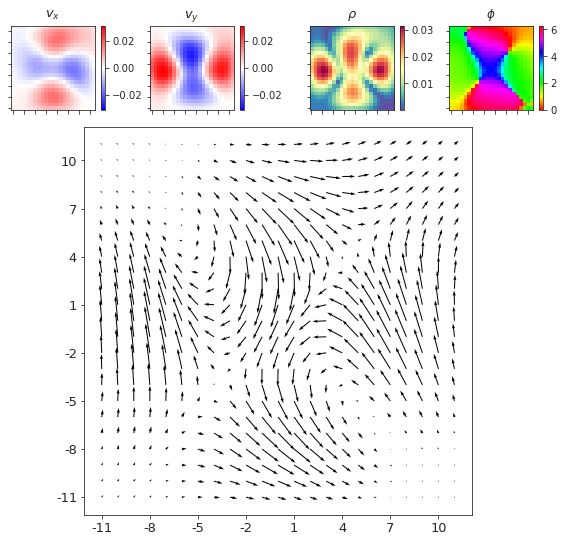

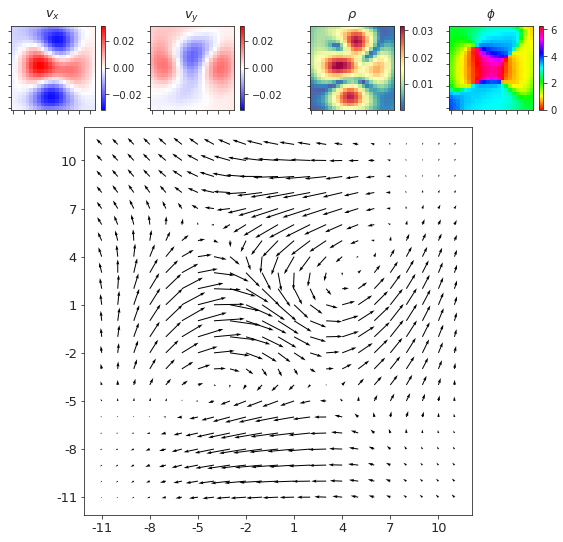

In [69]:
for i in range(10):
    show_opticflow_full(data[i], scale=0.4);

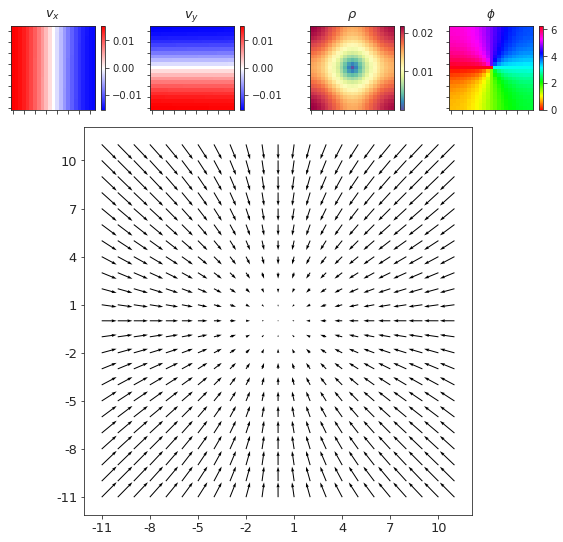

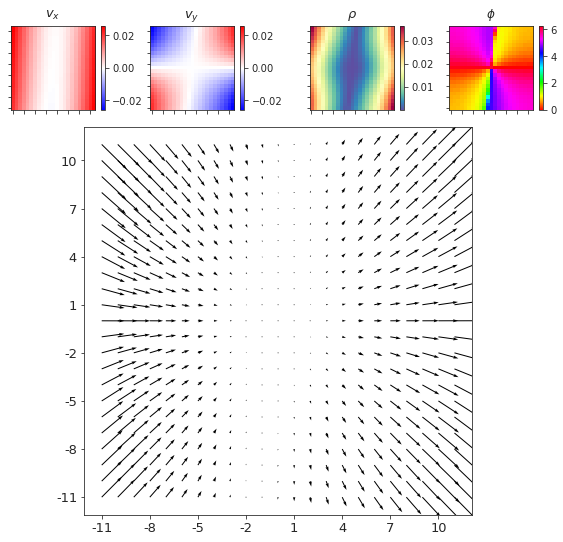

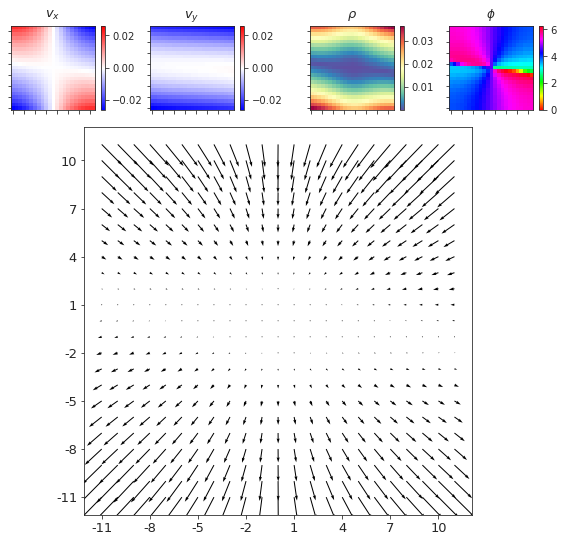

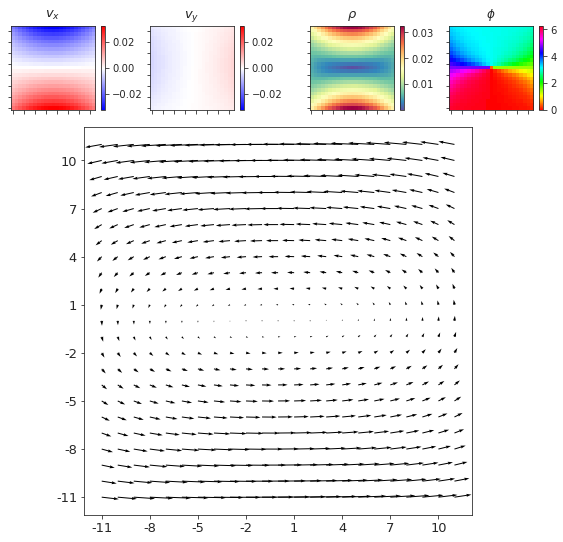

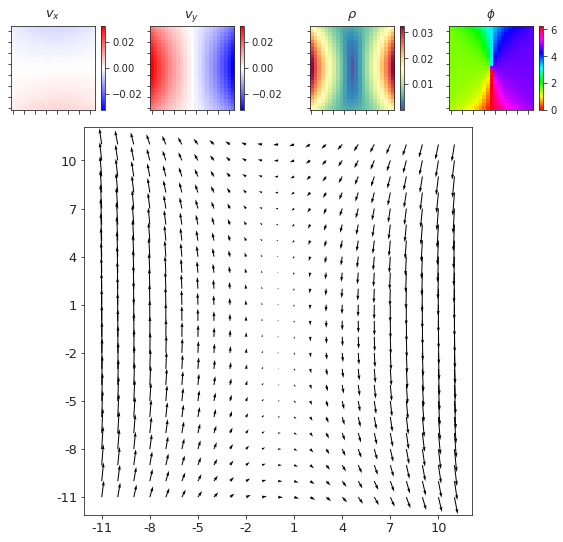

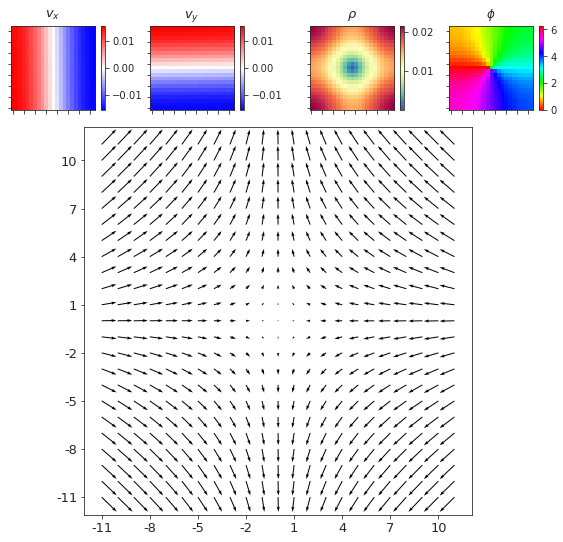

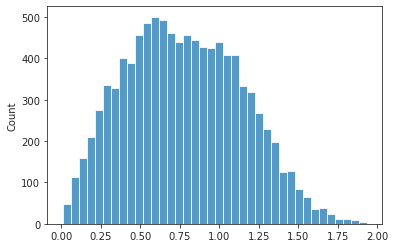

In [58]:
delta = sp_lin.norm(self.objects[0].alpha - self.objects[1].alpha, axis=1)
sns.histplot(delta);

In [72]:
np.where(np.logical_and(0.48 < delta, delta < 0.49))[0]

array([ 182,  226,  494,  496,  534,  585,  612,  963,  967, 1152, 1560,
       1614, 2133, 2214, 2461, 2488, 2741, 2786, 2859, 2890, 2989, 3089,
       3789, 3895, 4146, 4304, 4431, 4877, 4894, 4940, 5008, 5084, 5123,
       5162, 5188, 5358, 5485, 5493, 5511, 5876, 5928, 6046, 6051, 6397,
       6468, 6729, 6907, 6958, 6977, 7119, 7230, 7301, 7343, 7408, 7611,
       7615, 7641, 7835, 7864, 7886, 7899, 7903, 7963, 7970, 8234, 8328,
       8342, 8344, 8453, 8468, 8556, 8639, 8663, 8672, 8695, 8767, 9000,
       9021, 9190, 9219, 9329, 9371, 9382, 9674, 9846])

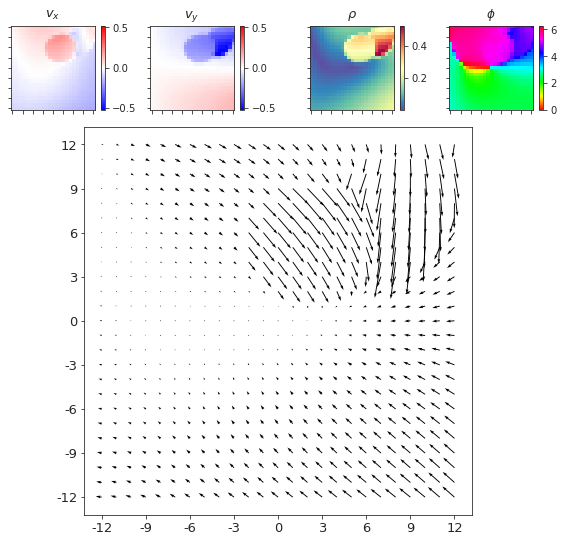

In [79]:
i = 5876 # np.argmin(delta)
d = 25
v = np.zeros((d, d, 2))
v[..., 0] = resize(self.alpha_dot[i, ..., 0], (d,) * 2)
v[..., 1] = resize(self.alpha_dot[i, ..., 1], (d,) * 2)

show_opticflow_full(v);

In [80]:
self.fix[i]

array([-0.12147092, -0.75780771,  1.        ])

In [ ]:
self.fix[i]

In [89]:
%%time

self = of = OpticFlow(
    category='fixate',
    num=10000,
    n_obj=2,
    vlim_slf=(0.01, 1.0),
    vlim_obj=(0.01, 1.0),
    fov=fov,
    res=res,
).compute_coords()
of.alpha.shape

CPU times: user 15.9 s, sys: 1.07 s, total: 17 s
Wall time: 17 s


(65, 65, 2)

In [90]:
self.fix

array([[ 0.27392337, -0.46042657,  1.        ],
       [ 0.21327155,  0.45899312,  1.        ],
       [ 0.08724998,  0.87014485,  1.        ],
       ...,
       [-0.33171479,  0.58736205,  1.        ],
       [-0.78013898, -0.18938395,  1.        ],
       [ 0.2002712 ,  0.31791632,  1.        ]])

In [ ]:
def sample_pos(self, flat_criterion: bool = True):
    bound = self.obj_bound * self.fov
    if flat_criterion:
        bound = np.tan(np.deg2rad(bound))
    pos = np_nans((self.num, 3))
    for i in range(self.num):
        while True:
            u = self.rng.normal(size=3)
            if flat_criterion:
                _, th, ph = cart2polar(
                    self.R[i].T @ u).ravel()
                a = np.tan(th) * np.cos(ph)
                b = np.tan(th) * np.sin(ph)
                cond = (
                    np.abs(a) < bound and
                    np.abs(b) < bound
                )
            else:
                c = sp_dist.cosine(self.fix[i], u)
                c = np.rad2deg(np.arccos(1 - c))
                cond = c < bound
            if cond:
                break
        _, th, ph = cart2polar(u).ravel()
        z = self.rng.uniform(
            low=self.obj_zlim[0],
            high=self.obj_zlim[1],
        )
        pos[i] = polar2cart(np.array(
            [z / np.cos(th), th, ph]
        )).ravel()
    assert not np.isnan(pos).sum()
    return pos

In [13]:
_Obj = collections.namedtuple(
	typename='Object',
	field_names=[
		'pos', 'v',      # coordinate system: real
		'alpha', 'r',  # coordinate system: self
		'size'],
)

In [25]:
obj_masks = {}
for obj_i in tqdm(range(self.n_obj)):
    if self.category == 'pursuit' and obj_i == 0:
        pos = self.fix.copy()
        pos[:, 2] = self.rng.uniform(
            low=self.obj_zlim[0],
            high=self.obj_zlim[1],
        )
    else:
        pos = self.sample_pos(flat_criterion=True)
    pos_self = self.apply_rot(pos, transpose=True)
    mask = self.compute_obj_mask(pos)
    kws = dict(
        pos=pos,
        v=self.sample_vel(*self.vlim_obj),
        alpha=np.stack([
            np.arctan2(pos_self[:, 0], pos_self[:, 2]),
            np.arctan2(pos_self[:, 1], pos_self[:, 2]),
        ], axis=1),
        r=cart2polar(pos_self),
        size=mask.mean(-1).mean(-1),
    )
    self.objects[obj_i] = _Obj(**kws)
    obj_masks[obj_i] = mask

  0%|          | 0/2 [00:00<?, ?it/s]

In [23]:
mask = (
    obj_pos[0][:, 2].reshape(-1, 1, 1) * obj_masks[0] +
    obj_pos[1][:, 2].reshape(-1, 1, 1) * obj_masks[1]
) 
mask.shape

(10000, 65, 65)

In [26]:
x_obj = self.x_bg.copy()
for i in range(self.num):
    obj_z = {
        obj_i: obj.pos[i, 2] for
        obj_i, obj in self.objects.items()
    }
    order, obj_z = zip(*sorted(
        obj_z.items(),
        key=lambda t: t[1],
        reverse=True,
    ))
    for obj_i, z in zip(order, obj_z):
        m = obj_masks[obj_i][i]
        x_obj[i, ..., -1][m] = z

In [32]:
x = self.apply_rot(x_obj, transpose=True)

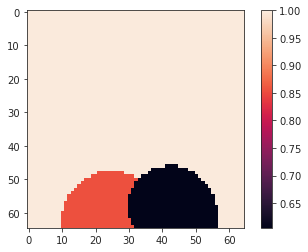

In [42]:
i = 129
plt.imshow(x_obj[i, ..., 2])
plt.colorbar()

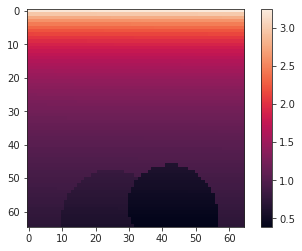

In [43]:
plt.imshow(x[i, ..., 2])
plt.colorbar()

In [54]:
pos = np.zeros((100000, 2))
for i in range(100000):
    length = np.sqrt(np.random.uniform(0, 1))
    angle = np.pi * np.random.uniform(0, 2)

    pos[i, 0] = length * np.cos(angle)
    pos[i, 1] = length * np.sin(angle)

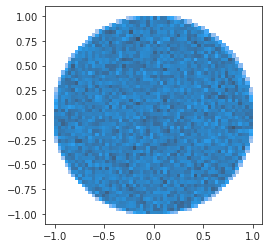

In [55]:
ax = sns.histplot(x=pos[:, 0], y=pos[:, 1])
ax_square(ax);

In [56]:
theta_0 = 80
r = self.z_bg / np.cos(np.deg2rad(theta_0))
r

5.758770483143631

In [57]:
pos = np.zeros((100000, 2))
for i in range(100000):
    length = np.sqrt(np.random.uniform(0, r))
    angle = np.pi * np.random.uniform(0, 2)

    pos[i, 0] = length * np.cos(angle)
    pos[i, 1] = length * np.sin(angle)

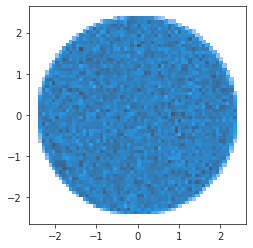

In [58]:
ax = sns.histplot(x=pos[:, 0], y=pos[:, 1])
ax_square(ax);

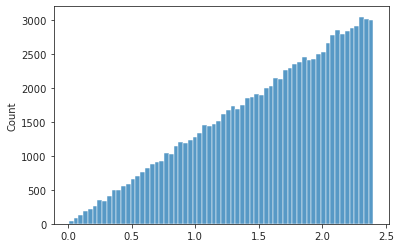

In [63]:
norm = np.sqrt(pos[:, 0] ** 2 + pos[:, 1] ** 2)
sns.histplot(norm);

In [66]:
theta = np.arctan(norm / self.z_bg)

<AxesSubplot:ylabel='Count'>

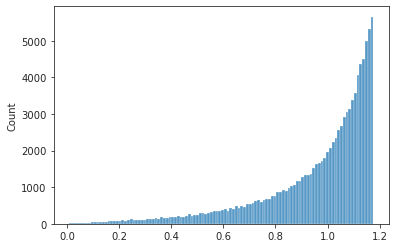

In [67]:
sns.histplot(theta)

In [108]:
theta = np.arccos(self.rng.uniform(
    low=np.cos(np.max(theta)), 
    high=1,
    size=self.num,
))
phi = self.rng.uniform(
    low=0,
    high=2 * np.pi,
    size=self.num,
)

<AxesSubplot:ylabel='Count'>

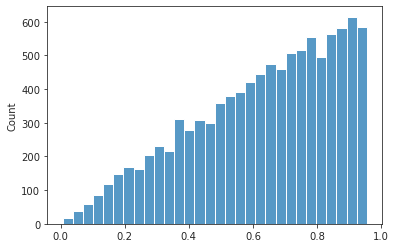

In [109]:
sns.histplot(theta)

In [111]:
u = np.stack([np.ones(self.num), theta, phi], axis=1)
u.shape

(10000, 3)

<AxesSubplot:ylabel='Count'>

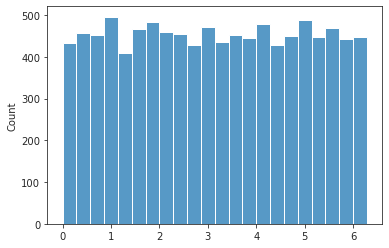

In [114]:
sns.histplot(u[:, 2])

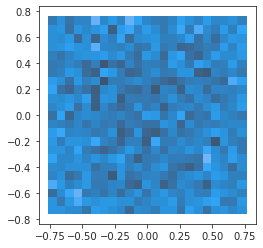

In [116]:
ax = sns.histplot(x=self.objects[0].alpha[:, 0], y=self.objects[0].alpha[:, 1])
ax_square(ax);

In [118]:
self.alpha.shape

(65, 65, 2)

In [288]:
self.obj_bound = 0.97
self.obj_bound

0.97

In [299]:
self.span

array([-0.78539816, -0.76085447, -0.73631078, -0.71176709, -0.68722339,
       -0.6626797 , -0.63813601, -0.61359232, -0.58904862, -0.56450493,
       -0.53996124, -0.51541754, -0.49087385, -0.46633016, -0.44178647,
       -0.41724277, -0.39269908, -0.36815539, -0.3436117 , -0.319068  ,
       -0.29452431, -0.26998062, -0.24543693, -0.22089323, -0.19634954,
       -0.17180585, -0.14726216, -0.12271846, -0.09817477, -0.07363108,
       -0.04908739, -0.02454369,  0.        ,  0.02454369,  0.04908739,
        0.07363108,  0.09817477,  0.12271846,  0.14726216,  0.17180585,
        0.19634954,  0.22089323,  0.24543693,  0.26998062,  0.29452431,
        0.319068  ,  0.3436117 ,  0.36815539,  0.39269908,  0.41724277,
        0.44178647,  0.46633016,  0.49087385,  0.51541754,  0.53996124,
        0.56450493,  0.58904862,  0.61359232,  0.63813601,  0.6626797 ,
        0.68722339,  0.71176709,  0.73631078,  0.76085447,  0.78539816])

In [300]:
alpha.shape

(10000, 2)

In [ ]:
_Obj = collections.namedtuple(
	typename='Object',
	field_names=[
		'pos', 'v',      # coordinate system: real
		'alpha', 'r',  # coordinate system: self
		'size'],
)

In [290]:
bound = self.obj_bound * self.fov
bound = np.deg2rad(bound)
bound

0.7618362184955249

In [291]:
len(self.span[np.logical_and(-bound < self.span, self.span < bound)])

63

In [292]:
# bound = self.obj_bound * self.fov
# bound = np.deg2rad(bound)

# alpha = self.rng.uniform(
#     low=-bound,
#     high=bound,
#     size=(self.num, 2),
# )
alpha = self.rng.choice(
    a=self.span[np.logical_and(
        -bound < self.span,
        self.span < bound)],
    replace=True,
    size=(self.num, 2),
)
theta, phi = radself2polar(
    a=alpha[:, 0],
    b=alpha[:, 1],
)
u = [np.ones(self.num), theta, phi]
u = polar2cart(np.stack(u, axis=1))
u = self.apply_rot(u, transpose=False)
u = cart2polar(u)
z = self.rng.uniform(
    low=self.obj_zlim[0],
    high=self.obj_zlim[1],
    size=self.num,
)
pos = [z / np.cos(u[:, 1]), u[:, 1], u[:, 2]]
pos = polar2cart(np.stack(pos, axis=1))
pos.shape

(10000, 3)

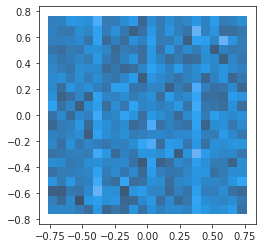

In [293]:
ax = sns.histplot(x=alpha[:, 0], y=alpha[:, 1])
ax_square(ax);

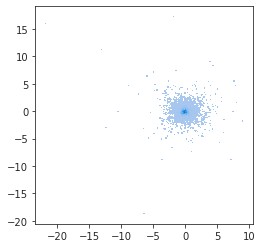

In [294]:
ax = sns.histplot(x=pos[:, 0], y=pos[:, 1])
ax_square(ax);

<AxesSubplot:ylabel='Count'>

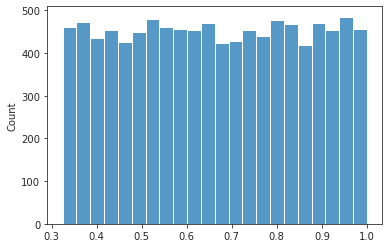

In [295]:
sns.histplot(pos[:, 2])

In [296]:
sp_stats.pearsonr(self.fix[:, 0], pos[:, 0]), sp_stats.pearsonr(self.fix[:, 1], pos[:, 1])

((0.5139904905163384, 0.0), (0.5093883845946969, 0.0))

In [297]:
sp_stats.pearsonr(self.fix[:, 0], self.fix[:, 0] - pos[:, 0])

(-0.03291322293422943, 0.0009954744790164956)

In [298]:
sp_stats.pearsonr(self.fix[:, 1], self.fix[:, 1] - pos[:, 1])

(-0.03326642641091851, 0.0008773988858183745)

In [262]:
mask = self.compute_obj_mask(pos)

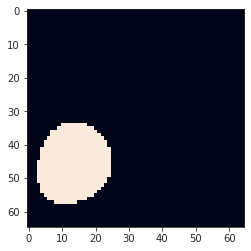

In [263]:
plt.imshow(mask[120])

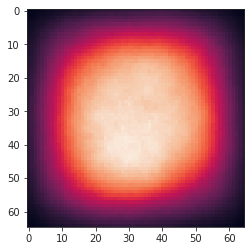

In [264]:
plt.imshow(mask.mean(0))

In [265]:
sizes = mask.sum(1).sum(1)

<AxesSubplot:ylabel='Count'>

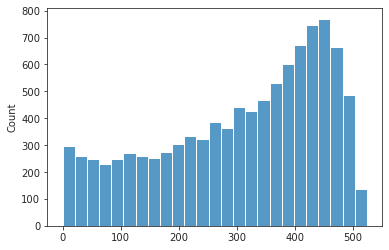

In [266]:
sns.histplot(sizes)

In [267]:
pos_self = self.apply_rot(pos, transpose=True)
r = cart2polar(pos_self)

In [268]:
np.argsort(r[:, 1])[::-1][:10]

array([ 794, 2862, 5055, 9957, 2278, 2523, 3703, 2865, 6524, 1101])

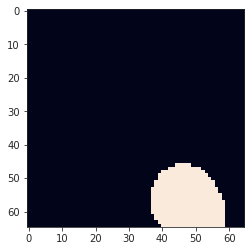

In [269]:
plt.imshow(mask[1944])

In [270]:
r[1944, 1], np.arccos(1 - sp_dist.cosine(pos[1944, :], self.fix[1944]))

(0.6940479576623331, 0.6940479576623331)

In [271]:
np.rad2deg(r[1944, 1])

39.76601875372613

In [272]:
np.rad2deg(np.max(self.theta))

54.735610317245346

In [273]:
alpha[1944]

array([0.41724277, 0.61359232])

In [274]:
ta = np.tan(alpha[1944, 0])
tb = np.tan(alpha[1944, 1])
theta = np.sqrt(ta**2 + tb**2)
theta = np.arctan(theta)
theta

0.6940479576623332

<AxesSubplot:ylabel='Count'>

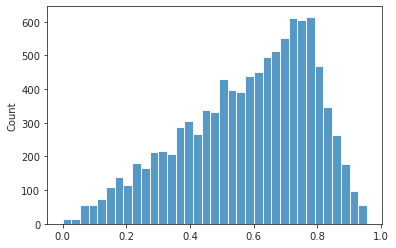

In [275]:
sns.histplot(r[:, 1])

In [276]:
alpha_computed = np.stack([
    np.arctan2(pos_self[:, 0], pos_self[:, 2]),
    np.arctan2(pos_self[:, 1], pos_self[:, 2]),
], axis=1)

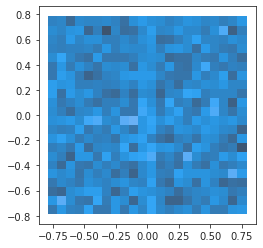

In [277]:
ax = sns.histplot(x=alpha_computed[:, 0], y=alpha_computed[:, 1])
ax_square(ax);

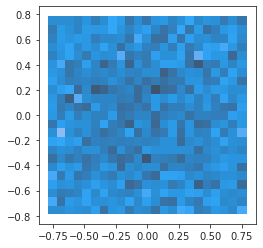

In [278]:
ax = sns.histplot(x=self.objects[0].alpha[:, 0], y=self.objects[0].alpha[:, 1])
ax_square(ax);

In [140]:
mask = self.compute_obj_mask(self.objects[0].pos)

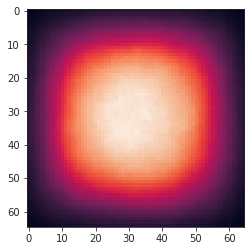

In [142]:
plt.imshow(mask.mean(0))

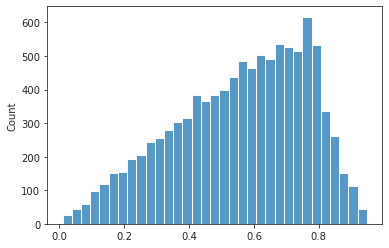

In [146]:
sns.histplot(self.objects[0].r[:, 1]);

In [88]:
for _ in range(5):
    print(self.sample_pos())

[[ 0.19962233 -0.15690462  0.96086846]]

[[0.31838468 0.0167031  0.68181502]]

[[0.46698779 0.27845735 0.80473259]]

[[ 0.2948436  -0.23959355  0.35138524]]

[[-0.2379231  -0.81715871  0.89273048]]

[[ 0.14714363 -1.56429708  0.76150011]]

[[ 0.71592304 -0.60357253  0.72574682]]

[[ 0.00147135 -0.21685565  0.42558892]]

[[-0.13038616 -0.21112352  0.3591664 ]]

[[-0.17973232 -0.48174662  0.71630469]]

In [45]:
for i, j in itertools.product(range(2), range(2)):
    if i == j:
        continue
    corr = sp_stats.pearsonr(self.objects[1].alpha[:, i], self.objects[4].alpha[:, j])[0]
    print(i, j, np.round(corr, 3))

0 1 -0.009

1 0 0.003

In [25]:
alpha_all = np.stack([
    obj.alpha for obj in
    self.objects.values()
], axis=-1)
alpha_all.shape

(100000, 2, 8)

In [26]:
a = alpha_all.mean(-1)
a.shape

(100000, 2)

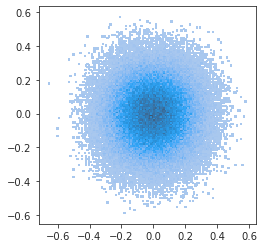

In [27]:
ax = sns.histplot(x=a[:, 0], y=a[:, 1])
ax_square(ax);

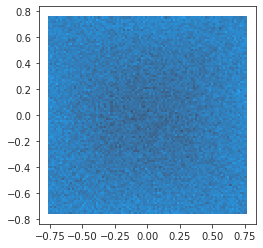

In [30]:
ax = sns.histplot(x=alpha_all[:, 0, :].ravel(), y=alpha_all[:, 1, :].ravel())
ax_square(ax);

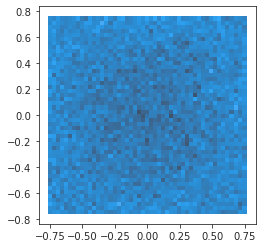

In [31]:
ax = sns.histplot(x=alpha_all[:, 0, 4].ravel(), y=alpha_all[:, 1, 4].ravel())
ax_square(ax);

In [46]:
obj_masks = {
    obj_i: self.compute_obj_mask(obj.pos)
    for obj_i, obj in self.objects.items()
}

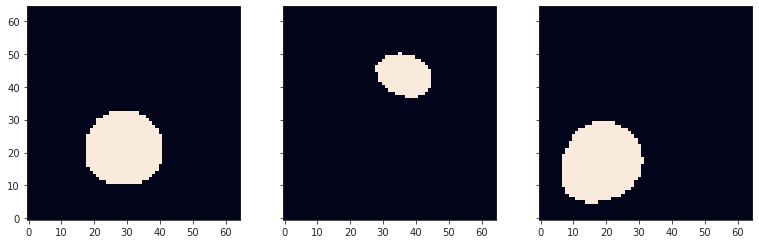

In [47]:
fig, axes = create_figure(1, 3, (13, 4), 'all', 'all')
for obj_i, ax in enumerate(axes.flat, start=1):
    ax.imshow(obj_masks[obj_i][i])
    ax.invert_yaxis()
plt.show()

In [66]:
i = 200
obj_z = {
    obj_i: obj.pos[i, 2] for
    obj_i, obj in self.objects.items()
}
order, obj_z = zip(*sorted(
    obj_z.items(), 
    key=lambda t: t[1],
    reverse=True,
))
order, obj_z

((3, 7, 8, 11, 15, 1, 13, 9, 2, 14, 12, 16, 6, 4, 5, 10),
 (0.880074816993532,
  0.8514233624972034,
  0.811518088986283,
  0.7986280046616616,
  0.7653652995556307,
  0.7440066956223077,
  0.7138837511525279,
  0.6798982214253513,
  0.6735244431858847,
  0.5619469576682877,
  0.5539366972912327,
  0.5052356825582347,
  0.42697085895160336,
  0.39195447659433585,
  0.36379794191208537,
  0.3567020452771259))

In [67]:
m = np.zeros((self.dim, self.dim))
for obj_i in order:
    m[obj_masks[obj_i][i]] = obj_i

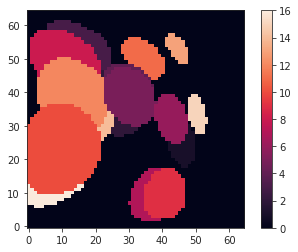

In [68]:
fig, ax = create_figure()
im = ax.imshow(m)
plt.colorbar(im, ax=ax)
ax.invert_yaxis();

In [69]:
len(unique_idxs(m))

16

In [70]:
self.fix[i]

array([0.71687065, 0.2418178 , 1.        ])

In [59]:
x_obj = self.x_bg.copy()
v_tr = np.zeros((self.num, self.dim, self.dim, 3))
for i in range(self.num):
    obj_z = {
        obj_i: obj.pos[i, 2] for
        obj_i, obj in self.objects.items()
    }
    order, obj_z = zip(*sorted(
        obj_z.items(),
        key=lambda t: t[1],
        reverse=True,
    ))
    for obj_i, z in zip(order, obj_z):
        m = obj_masks[obj_i][i]
        x_obj[i, ..., -1][m] = z
        for j in range(3):
            v = self.objects[obj_i].v[i, j]
            v_tr[i, ..., j][m] = v
x_obj = self.apply_rot(x_obj, transpose=True)
v_tr = self.apply_rot(v_tr, transpose=True)

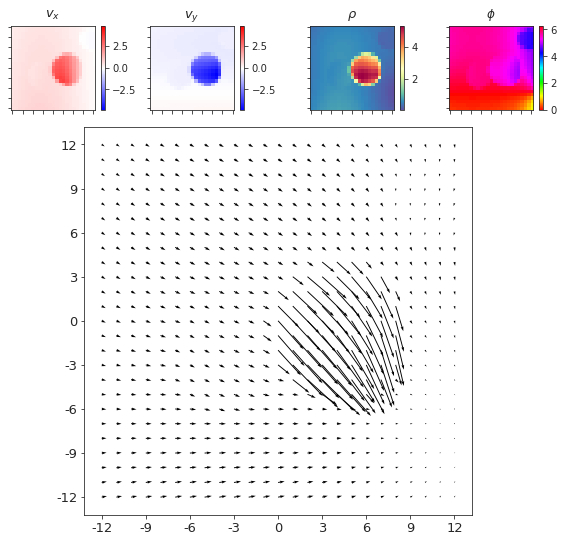

In [9]:
obj = objects[1]
m = masks[1]

obj.v.shape, obj.pos.shape, m.shape

((1000, 3), (1000, 3), (1000, 65, 65))

In [10]:
v_transl = self._compute_v_tr(obj.v)
# v_transl is in self's coordinate system
v_transl.shape

(1000, 65, 65, 3)

In [11]:
x_obj = self.x_bg.copy()
for i in range(self.num):
    x_obj[i, ..., -1][m[i]] = obj.pos[i, -1]
x_obj = self.apply_rot(x_obj, transpose=True)
# now: x_obj is in self's coordinate system

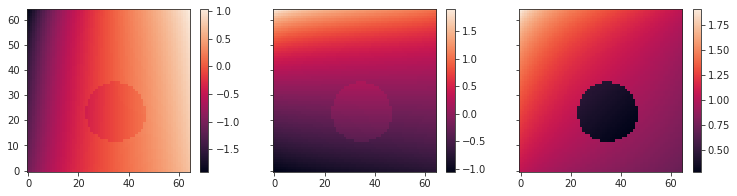

In [12]:
fig, axes = create_figure(1, 3, (12.5, 3), 'all', 'all')
for i, ax in enumerate(axes.flat):
    im = ax.imshow(x_obj[146, ..., i])
    plt.colorbar(im, ax=ax)
    ax.invert_yaxis()
plt.show()

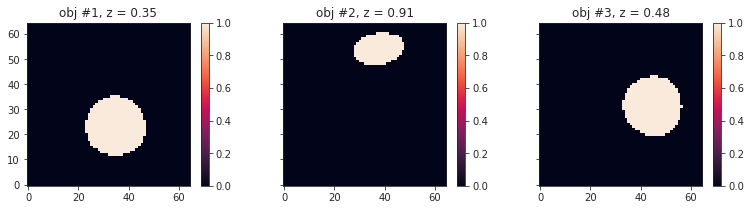

In [18]:
i = 146
fig, axes = create_figure(1, 3, (13, 3), 'all', 'all')
for obj_i, ax in enumerate(axes.flat, start=1):
    ax.set_title(f"obj #{obj_i}, z = {objects[obj_i].pos[ii, 2]:0.2f}")
    im = ax.imshow(masks[obj_i][i])
    plt.colorbar(im, ax=ax)
    ax.invert_yaxis()

In [45]:
i = 146
obj_z = {
    obj_i: obj.pos[i, 2] for
    obj_i, obj in self.objects.items()
}
order, obj_z = zip(*sorted(
    obj_z.items(), 
    key=lambda t: t[1],
    reverse=True,
))
order, obj_z

((2, 3, 1), (0.9124281049682237, 0.4839207051759733, 0.3516704320060139))

In [46]:
m = np.zeros((self.dim, self.dim))
for obj_i in order:
    m[masks[obj_i][i]] = obj_i

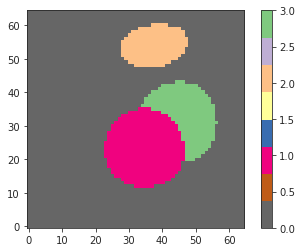

In [47]:
fig, ax = create_figure()
im = ax.imshow(m, cmap='Accent_r')
plt.colorbar(im, ax=ax)
ax.invert_yaxis();

In [48]:
for obj_i, z in zip(order, obj_z):
    x_obj[i, ..., -1][masks[obj_i][i]] = z

In [49]:
x_obj = self.apply_rot(x_obj, transpose=True)

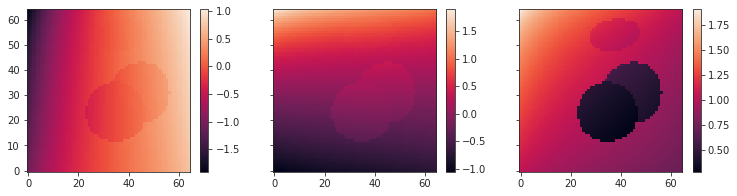

In [50]:
fig, axes = create_figure(1, 3, (12.5, 3), 'all', 'all')
for j, ax in enumerate(axes.flat):
    im = ax.imshow(x_obj[i, ..., j])
    plt.colorbar(im, ax=ax)
    ax.invert_yaxis()
plt.show()

In [101]:
x_obj = self.x_bg.copy()
m_obj = np.zeros((self.num, self.dim, self.dim))
v_transl = np.zeros((self.num, self.dim, self.dim, 3))
for i in range(self.num):
    obj_z = {
        obj_i: obj.pos[i, 2] for
        obj_i, obj in self.objects.items()
    }
    order, obj_z = zip(*sorted(
        obj_z.items(), 
        key=lambda t: t[1],
        reverse=True,
    ))
    # start: possibly unneeded
    for obj_i in order:
        m_obj[i][masks[obj_i][i]] = obj_i
    # end: possibly unneeded
    for obj_i in order:
        m = masks[obj_i][i]
        z = self.objects[obj_i].pos[i, 2]
        x_obj[i, ..., -1][m] = z
        for j in range(3):
            v = self.objects[obj_i].v[i, j]
            v_transl[i, ..., j][m] = v

x_obj = self.apply_rot(x_obj, transpose=True)
v_transl = self.apply_rot(v_transl, transpose=True)
x_obj.shape, v_transl.shape

((1000, 65, 65, 3), (1000, 65, 65, 3))

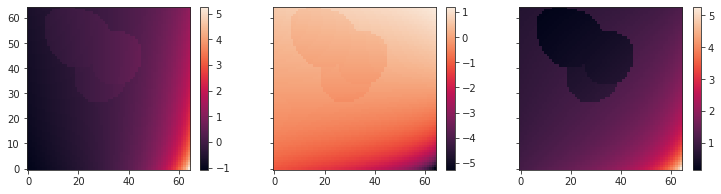

In [102]:
i = 153

fig, axes = create_figure(1, 3, (12.5, 3), 'all', 'all')
for j, ax in enumerate(axes.flat):
    im = ax.imshow(x_obj[i, ..., j])
    plt.colorbar(im, ax=ax)
    ax.invert_yaxis()
plt.show()

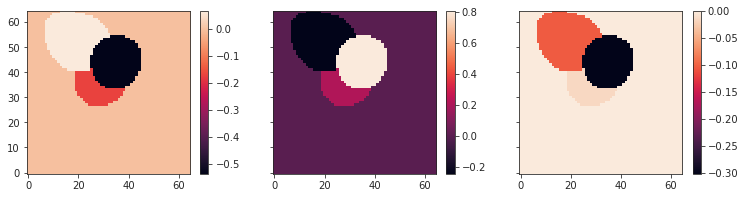

In [104]:
i = 153

fig, axes = create_figure(1, 3, (12.5, 3), 'all', 'all')
for j, ax in enumerate(axes.flat):
    im = ax.imshow(v_transl[i, ..., j])
    plt.colorbar(im, ax=ax)
    ax.invert_yaxis()
plt.show()

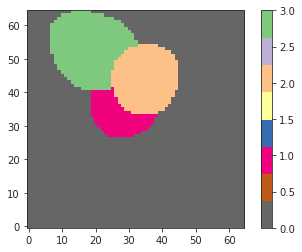

In [106]:
fig, ax = create_figure()
im = ax.imshow(m_obj[i], cmap='Accent_r')
plt.colorbar(im, ax=ax)
ax.invert_yaxis();

In [107]:
print({
    obj_i: obj.pos[i, 2] for
    obj_i, obj in self.objects.items()
})

{1: 0.5207490681321417, 2: 0.34087524542287545, 3: 0.35527375541019524}

In [108]:
print({
    obj_i: obj.v[i, 2] for
    obj_i, obj in self.objects.items()
})

{1: 0.11790314330019189, 2: 0.19070495739681256, 3: -0.1922796457134923}

In [114]:
v_tr = self._compute_v_tr(self.objects[2].v)
v_tr[i, self.dim//2, self.dim//2, 2]

-0.30156062123004446

In [115]:
v_tr = self._compute_v_tr(self.objects[3].v)
v_tr[i, self.dim//2, self.dim//2, 2]

-0.10248415346341125

In [116]:
v_tr = self._compute_v_tr(self.objects[1].v)
v_tr[i, self.dim//2, self.dim//2, 2]

-0.014349742346900396

In [119]:
v_slf = self.sample_vel(*self.vlim_slf)
v_slf = self._compute_v_tr(v_slf)
v_slf.shape

(1000, 65, 65, 3)

In [120]:
v_transl.shape

(1000, 65, 65, 3)

In [121]:
v_transl -= v_slf

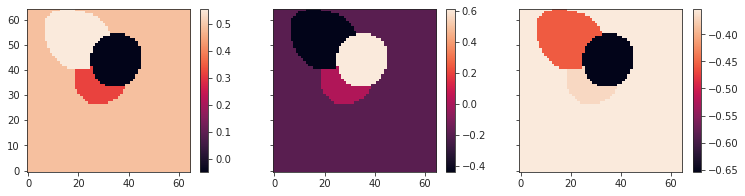

In [122]:
i = 153

fig, axes = create_figure(1, 3, (12.5, 3), 'all', 'all')
for j, ax in enumerate(axes.flat):
    im = ax.imshow(v_transl[i, ..., j])
    plt.colorbar(im, ax=ax)
    ax.invert_yaxis()
plt.show()

In [123]:
def _compute_alpha_dot(
        self,
        v: np.ndarray,
        x: np.ndarray = None,
        axis: int = 3, ):
    if x is None:
        x = self.x
    delta = v.ndim - x.ndim
    if delta > 0:
        for n in v.shape[-delta:]:
            x = _expand(x, n, -1)
    alpha_dot = []
    for i in [0, 1]:
        a = (
            v.take(i, axis) * x.take(2, axis) -
            v.take(2, axis) * x.take(i, axis)
        )
        a /= sp_lin.norm(
            x.take([i, 2], axis),
            axis=axis,
        ) ** 2
        a = np.expand_dims(a, axis)
        alpha_dot.append(a)
    alpha_dot = np.concatenate(alpha_dot, axis)
    return alpha_dot

In [124]:
alpha_dot = _compute_alpha_dot(self, v=v_transl, x=x_obj)

In [125]:
alpha_dot.shape

(1000, 65, 65, 2)

In [126]:
from figures.fighelper import show_opticflow, show_opticflow_full

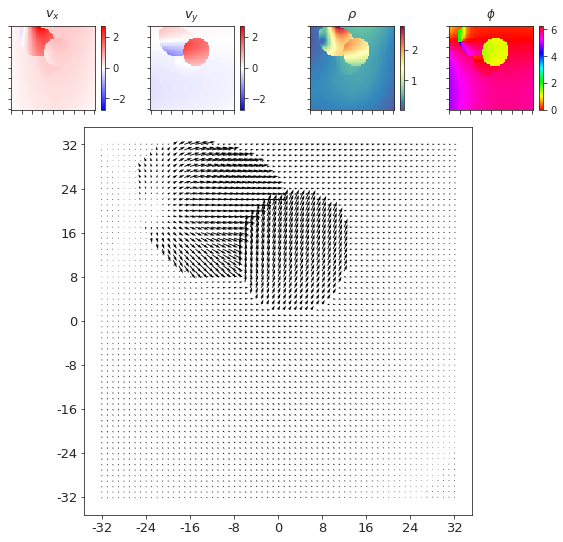

In [131]:
show_opticflow_full(alpha_dot[i], tick_spacing=8);

In [135]:
from skimage.transform import resize

In [136]:
alpha_dot[i].shape

(65, 65, 2)

In [143]:
d = 25
v = np.zeros((d, d, 2))
v[..., 0] = resize(alpha_dot[i, ..., 0], (d,) * 2)
v[..., 1] = resize(alpha_dot[i, ..., 1], (d,) * 2)

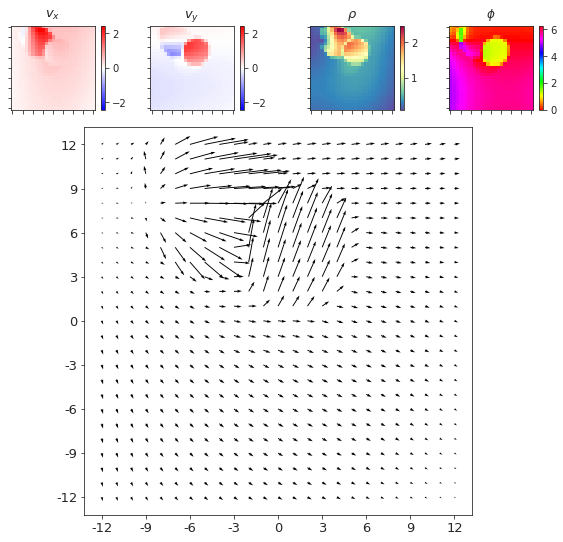

In [144]:
show_opticflow_full(v);

In [82]:
x_obj.shape

(1000, 65, 65, 3)

In [85]:
v_transl[i][masks[obj_i][i]].shape

(292, 3)

In [76]:
v_transl = self.apply_rot(obj.v, transpose=True)

In [77]:
v_transl.shape

(1000, 3)

In [18]:
v_transl[~m] = 0

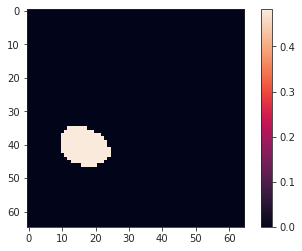

In [22]:
plt.imshow(v_transl[452, ..., 2])
plt.colorbar()

In [23]:
v_transl[452, ..., 2]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [71]:
x = dc(self.x)
x[..., -1][m].shape

(309081,)

In [72]:
obj.x.shape

(1000, 3)

True

In [ ]:
x_obj = self.x_bg.copy()
for i in range(self.num):
    x_obj[i, ..., -1][np.where(mask[i])] = pos[i, 2]
x_obj_in_self = 'aij, axyi -> axyj'
x_obj_in_self = np.einsum(x_obj_in_self, self.R, x_obj)

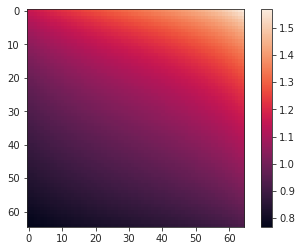

In [69]:
plt.imshow(x[120, ..., 2])
plt.colorbar()

In [49]:
(~np.isnan(x_obj)).sum()

927243

In [51]:
(~m).sum()

3915919

<AxesSubplot:ylabel='Count'>

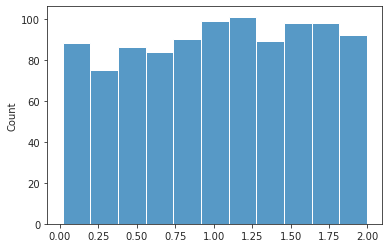

In [10]:
sns.histplot(cart2polar(obj.v)[:, 0])

In [28]:
v_slf = self.sample_vel(*self.vlim_slf)
v_slf.shape

(1000, 3)

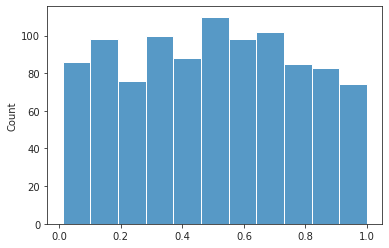

In [29]:
sns.histplot(cart2polar(v_slf)[:, 0]);

In [30]:
v_transl = 'aij, ai -> aj'
v_transl = np.einsum(v_transl, self.R, obj.v)

In [34]:
v_tr = np.repeat(np.repeat(np.expand_dims(np.expand_dims(
    v_transl, 1), 1), self.dim, 1), self.dim, 2)
v_tr.shape

(1000, 65, 65, 3)

In [31]:
v_transl.shape

(1000, 3)

In [33]:
m.shape

(1000, 65, 65)

In [35]:
v_tr[m]. shape

(309081, 3)

In [36]:
m.sum()

309081

In [37]:
def _expand(arr, reps, axis):
	return np.repeat(np.expand_dims(
		arr, axis=axis),
		repeats=reps,
		axis=axis,
	)

In [38]:
_expand(v_transl, self.dim, 1).shape

(1000, 65, 3)